<a href="https://colab.research.google.com/github/ep1lept1c/MSU_DL/blob/main/MSU_DL_08_MT_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение в глубокое обучение
## Занятие 8. Машинный перевод, Seq2Seq, Attention


##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

## План занятия

1. Задача машинного перевода. Архитектура Seq2Seq
2. Механизм Attention
3. Практика: машинный перевод

## Задача машинного перевода. Архитектура Seq2Seq

Задача машинного перевода состоит в том, чтобы найти наиболее вероятную последовательность токенов (перевод предложения) при условии заданной последовательности токенов (исходное предложение):

Кошка сидит на полу \\
($x_1, \ \ \ \ \ \ x_2, \ \ x_3, \ x_4$)

A $\ \ $ cat $\ $ is sitting on the floor \\
($y_1, y_2, y_3, \ \ y_4, \ y_5 \ y_6\ \ y_7$)

Задача машинного перевода:

$$\widehat{Y} = argmax_{Y} P(Y|X, \theta)$$

при этом это расписывается как
$$P(Y|X, \theta) = P(y_1 | X, \theta) \cdot P(y_2 |y_1, X, \theta) \cdot \dots P(y_n | y_{n-1}, y_{n-2}, \dots, y_1, X, \theta)$$

Мы видим, что постановка задачи машинного перевода похожа на постановку задачи языкового моделирования: модель так же должна авторегрессионно генерировать последовательность токенов. Отличие в том, что в случае машинного перевода добавляется условие, с учетом которого должна генерироваться выходная последовательность. Поэтому задачу машинного перевода можно назвать задачей **conditional language modeling**.

Давайте поговорим о том, как решать задачу машинного перевода с помощью RNN. Для этого кратко вспомним, как устроена модель для языкового моделирования.

Языковая модель — RNN в каждый момент времени принимает на вход токен и выдает на выходе распределение вероятностей на следующий токен.

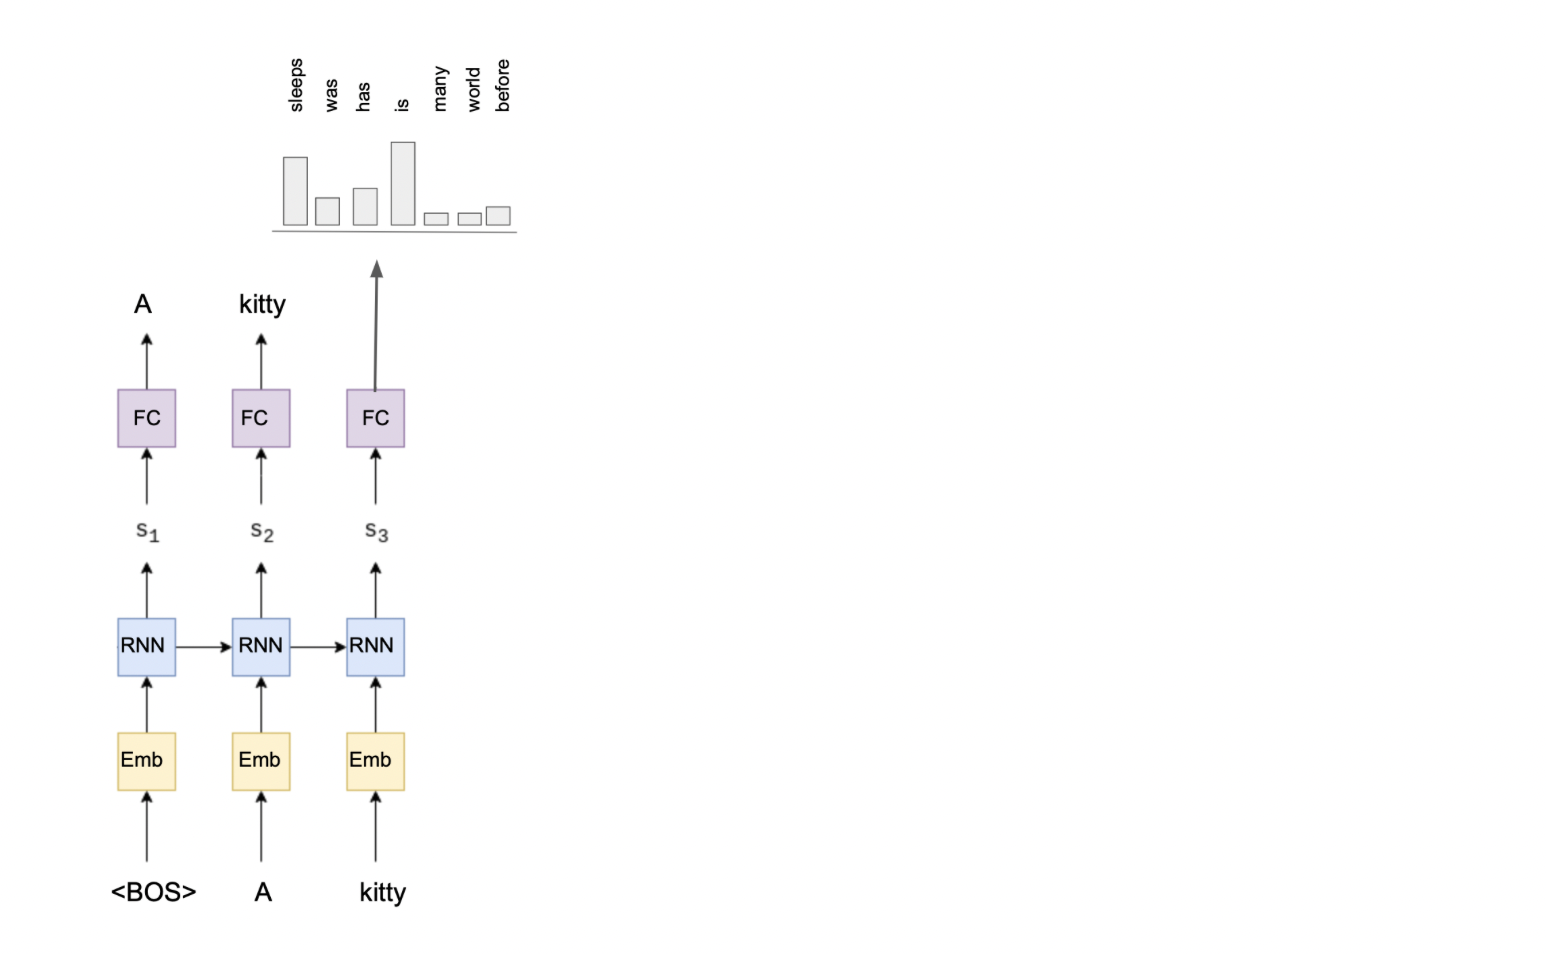

Давайте теперь построим RNN-модель для задачи машинного перевода. Она будет состоять из двух частей:

1. Часть-энкодер, которая обрабатывает исходное предложение токен за токеном. Эта часть будет RNN-сетью, у которой не будет полносвязного слоя в конце.
2. Часть-декодер, которая будет генерировать предложение-перевод токен за токеном. Эта часть также будет RNN-сетью. Устроена она будет так же, как сеть для языкового моделирования. От собственно сети для языкового моделирования у нее будет одно отличие: вектор скрытого состояния будет задаваться не случайно, а с помощью вектора скрытого состояния энкодера, который получился после обработки энкодером исходного предложения.

Вектор скрытого состояния энкодера после обработки исходного предложения будет содержать информацию об исходном предложении. И на основе этой информации декодер будет генерировать предложение-перевод.

Модель такого типа называется Sequence-to-Sequence (Seq2Seq), так как она принимает на вход последовательность и выдает на выходе тоже последовательность.

Перейдем в [слайды](https://docs.google.com/presentation/d/1kCLV59uJbQa_ivMqBgJjo-FuF3ejhaVhAChpfOQ45dk/edit?usp=sharing), где детально обсудим, как такая модель работает.

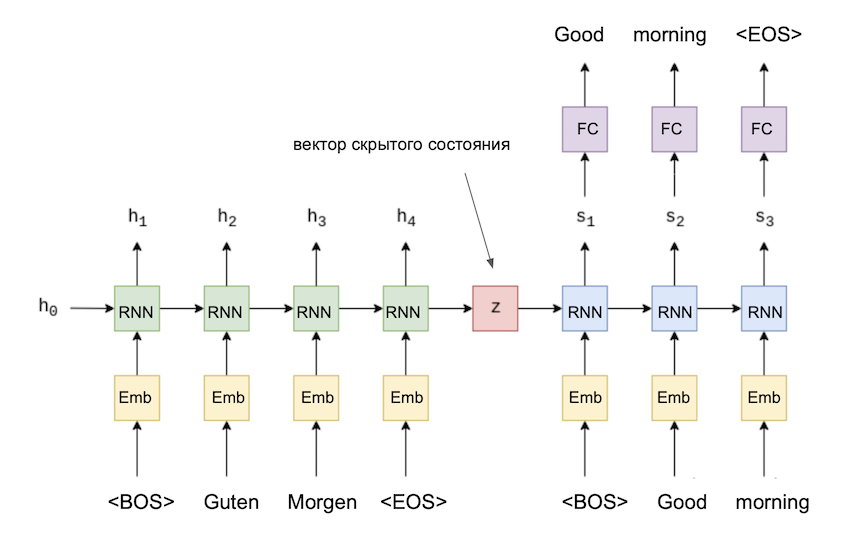

Здесь заметим вот что: пусть у нас есть модель, обученная подобным образом. Тогда часть-энкодер этой модели можно использовать для получения эмбеддингов предложений.

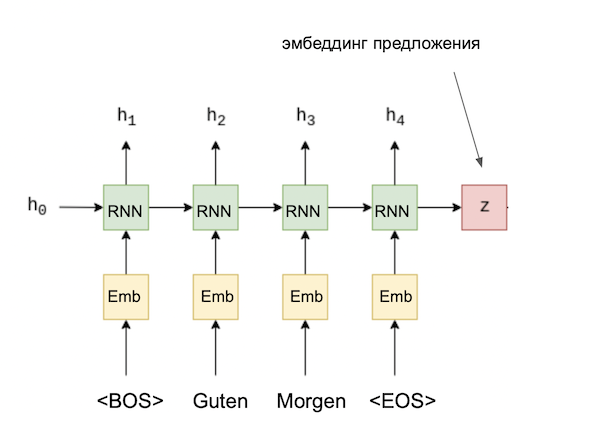

Другие модели, обученные на другие задачи, также можно использовать для получения эмбеддингов объектов (текстов, изображений и т.п.). Например, идея эмбеддингов [ELMO](https://youtu.be/zhsUpUFClEU?feature=shared) основана на обучении языковой модели и получении выходов ее слоев в ответ на входящий текст.

### Проблема архитектуры Seq2Seq

Описанная выше архитектура сети для машинного перевода была стандартной в 2014-2015 годах. Однако в те времена она уступала по качеству статистическим (phrase-based) моделям перевода. Причиной этому во многом была одна проблема, которая была у этой архитектуры: вся информация об исходном предложении выучивается RNN-слоями, и оказывается заключена в одном единственном векторе z.

Почему это проблема:
1. RNN подвержены "забыванию". Несмотря на то, что у RNN есть механизм "памяти", с течением времени информация из этой памяти стирается;
2. Предложения разной длины обрабатываются одним и тем же механизмом. Вся информация даже с самого длинного предложения собирается в одном векторе скрытого состояния z. Получается, количество информации, которое может быть передано декодеру, ограничено объемом вектора z.
3. Во время декодинга на каждом шаге декодер генерирует новый токен на основе своего вектора скрытого состояния. В процессе декодинга этот вектор скрытого состояния теряет информацию из энкодера, и последние сгенерированные токены могут иметь мало общего с изначальным предложением.



В течение долгого времени исследователи пытались придумать, как бороться с этим ограничением. Были придуманы много способов, которые улучшали качество, но проблему до конца не решали. И в 2015 году была предложена идея механизма внимания (Attention), которая позволила побороть эту проблему. Сейчас мы с ним познакомимся.

### Механизм внимания (Attention)

Перейдем в [презентацию](https://docs.google.com/presentation/d/1kCLV59uJbQa_ivMqBgJjo-FuF3ejhaVhAChpfOQ45dk/edit?usp=sharing), чтобы детально обсудить работу механизма внимания.

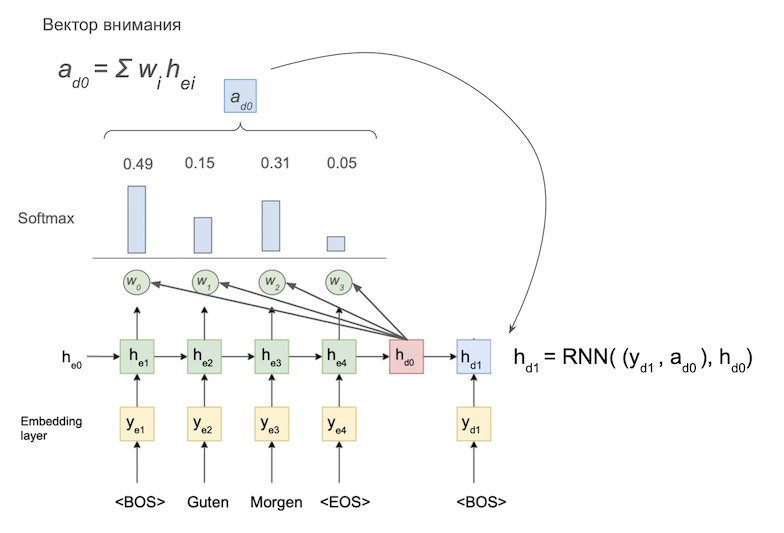

Механизм внимания позволяет интерпретировать работу модели:

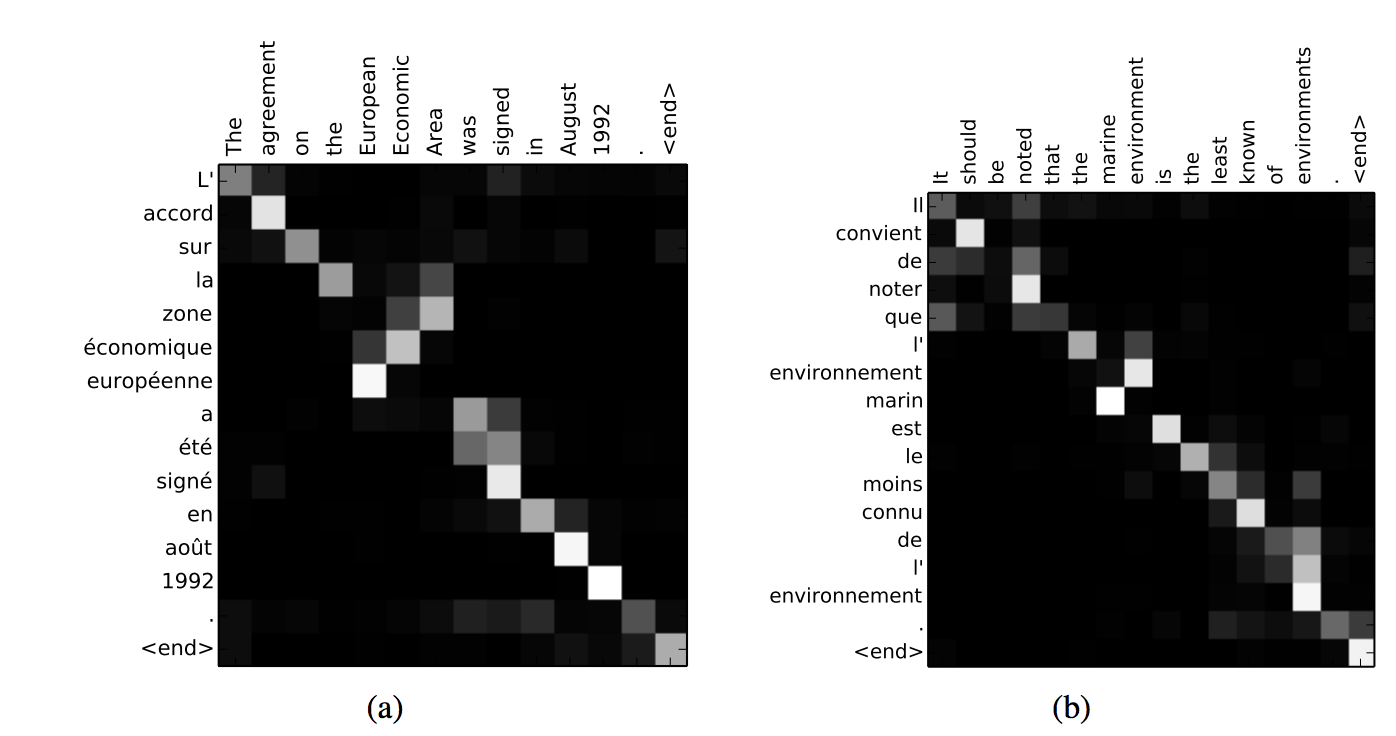

## Практика

### Загрузка и предобработка данных

In [ ]:
! pip install torch==1.13.0
! pip install torchtext
! pip install portalocker>=2.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 64.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu118
    Uninstalling torch-2.1.0+cu118:
      Successfully uninstalled torch-2.1.0+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu118 requires torch==2.1.0, but you have torch 1.13.0 which is incompatible.
torchdata 0.7.0 requires torch==2.1.0, but you have torch 1.13.0 which is incompatible.
torchtext 0.16.0 requires torch==2.1.0, but you have torch 1.13.0 

Загрузим параллельный корпус текстов. Это [корпус Multi30k](https://github.com/multi30k/dataset), который представляет собой набор данных из ~30 000 параллельных предложений на английском и немецком языках. Мы будем решать задачу машинного перевода с немецкого на английский язык.

In [ ]:
from torchtext.datasets import Multi30k


train_iter = Multi30k(split="train")

# torchtext.datasets.Multi30k выдает объект класса IterableDataset.
# переведем его в простой массив элементов
train_data = list(train_iter)

print(f"Количество тренировочных данных: {len(train_data)}")
print(train_data[0])

Количество тренировочных данных: 29001
('Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 'Two young, White males are outside near many bushes.')


Импортируем токенизатор:

In [ ]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()
print(tokenizer.tokenize("Good morning!"))

['Good', 'morning', '!']


И напишем функцию tokenize, с помощью которой будем разбивать на токены все предложения в данных:

In [ ]:
def tokenize(sent):
    return tokenizer.tokenize(sent.rstrip().lower())                              # привели к нижнему регистру и разбили на токены

src, trg = train_data[0]                                                          # берем первую пару "исходный язык" - "целевой язык"
                                                                                  # из обучающей выборки

print(tokenize(src))
print(tokenize(trg))

['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


Заведем словари английского и немецкого языков. Для этого воспользуемся torchtext.vocab.vocab

In [ ]:
from collections import Counter

from torchtext.vocab import vocab as Vocab


src_counter = Counter()
trg_counter = Counter()
for src, trg in train_data:
    src_counter.update(tokenize(src))
    trg_counter.update(tokenize(trg))

src_vocab = Vocab(src_counter, min_freq=2)                                        # минимальная частота встречаемости - 2
trg_vocab = Vocab(trg_counter, min_freq=2)

Добавим в словарь 4 дополнительных токена:
- UNK — токен, на который будем заменять слова, которых нет в словаре;
- BOS — begin of sentence;
- EOS — end of sentence;
- PAD — токен для паддинга.

In [ ]:
unk_token, bos_token, eos_token, pad_token = "<UNK>", "<BOS>", "<EOS>", "<PAD>"

for vocab in [src_vocab, trg_vocab]:
    vocab.insert_token(unk_token, index=0)
    vocab.set_default_index(0)

for vocab in [src_vocab, trg_vocab]:
    for token in [bos_token, eos_token, pad_token]:
        if token not in vocab:
            vocab.append_token(token)

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(src_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(trg_vocab)}")

Unique tokens in source (de) vocabulary: 7892
Unique tokens in target (en) vocabulary: 5903


Объединим всю предобработку предложения в функцию encode. Она будет токенизировать предложение и добавлять к нему вспомогательные токены BOS и EOS

In [ ]:
def encode(sent, vocab):                                                          # функция берет любую фразу и словарь, соответствующий ей
                                                                                  # т.е. либо словарь исходного или целевого языка
    tokenized = [bos_token] + tokenize(sent) + [eos_token]
    return [vocab[tok] for tok in tokenized]                                      # возвращает последовательность индексов токенов вместо фразы

src, trg = train_data[100]
print(encode(src, src_vocab))
print(encode(trg, trg_vocab))

[7889, 421, 422, 8, 26, 160, 199, 46, 157, 193, 55, 26, 423, 424, 13, 7890]
[5900, 434, 232, 14, 18, 163, 149, 289, 33, 111, 362, 435, 11, 5901]


Осталось написать функцию, которая будет составлять батчи из набора предложений. Мы помним, что для RNN все элементы батча должны иметь одинаковую длину. Как и на прошлом занятии, мы зафиксируем будем к коротким предложениям в батче добавлять токены PAD. Так мы добьемся того, что в каждом батче будут элементы одинаковой длины.

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# функция, позволяющая нам специфицировать, как именно из датасета строить батчи
def collate_batch(batch):
    src_list, trg_list = [], []                                                   # имеется два списка
    for src, trg in batch:                                                        # батч из обучающей выборки
        src_encoded = encode(src, src_vocab)                                      # закодируем элементы из батча, используя src_vocab
        src_list.append(torch.tensor(src_encoded))                                # добавим в список "исходников" строку в виде токенов,
                                                                                  # отображенных в индексы
        trg_encoded = encode(trg, trg_vocab)                                      # то же самое делаем с целевой фразой
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])       # "добьем" все токены до максимальной длины с помощью падтокена
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])

    return src_padded, trg_padded

<PAD>

Ну и, наконец, заведем тренировочный DataLoader на основе train_data с нашим collate_batch:

In [ ]:
batch_size = 256
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
src_batch, trg_batch = next(iter(train_dataloader))
src_batch.shape, trg_batch.shape

(torch.Size([46, 256]), torch.Size([38, 256]))

И так же заведем даталоадер для валидационной части данных:

In [ ]:
val_data = list(Multi30k(split="valid"))
val_dataloader = DataLoader(val_data, batch_size, collate_fn=collate_batch)

### Построение модели Seq2Seq

Сейчас мы построим модель Seq2Seq. Она будет состоять из двух частей — Encoder и Decoder.

**Encoder**

Модель-encoder будет однослойной двунаправленной RNN-сетью с GRU-слоями. GRU — это чуть модифицированный RNN-слой, который позволяет механизму памяти RNN работать чуть лучше (но все равно не идеально).

Двунаправленный RNN-слой — это, по сути, два слоя, один из которых "читает" текст слева направо, другой – справа налево. Изобразить это можно примерно так:

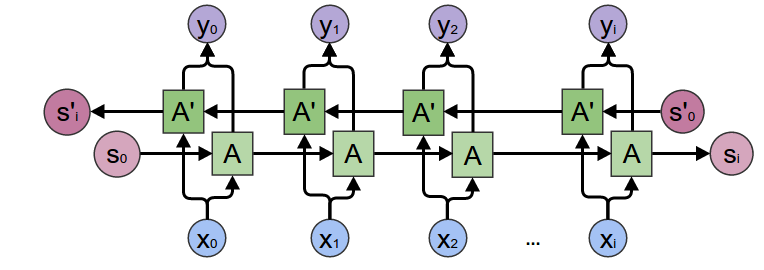

Для наглядности проиллюстрируем устройство RNN еще раз:

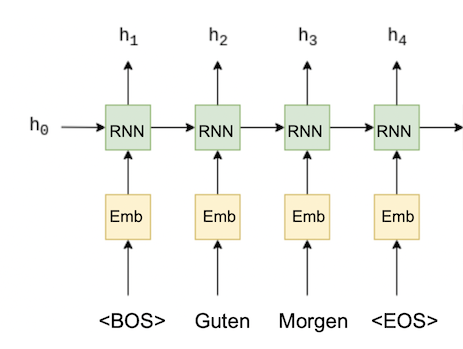

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# энкодер, получающий на вход батч из последовательности индексов токенов, а на выход отдает скрытое состояние
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        # слой эмбеддинг
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # для слоя Embedding будем использовать dropout
        self.dropout = nn.Dropout(dropout)

        # однослойная bidirectional GRU
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        # полносвязный слой
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)



    def forward(self, src):

        embedded = self.dropout(self.embedding(src))

        outputs, hidden = self.rnn(embedded)

        # получаем последние скрытые состояния обоих направлений GRU
        # каждое из них имеет размерность (256, 512)
        hidden = torch.tanh(self.fc(torch.cat((hidden[0,:,:], hidden[1,:,:]), dim = 1)))

        return outputs, hidden

Декодер будет однослойной GRU. Основное отличие декодера от энкодера в том, что его forward принимает на вход кроме токенов еще скрытое состояние от энкодера.

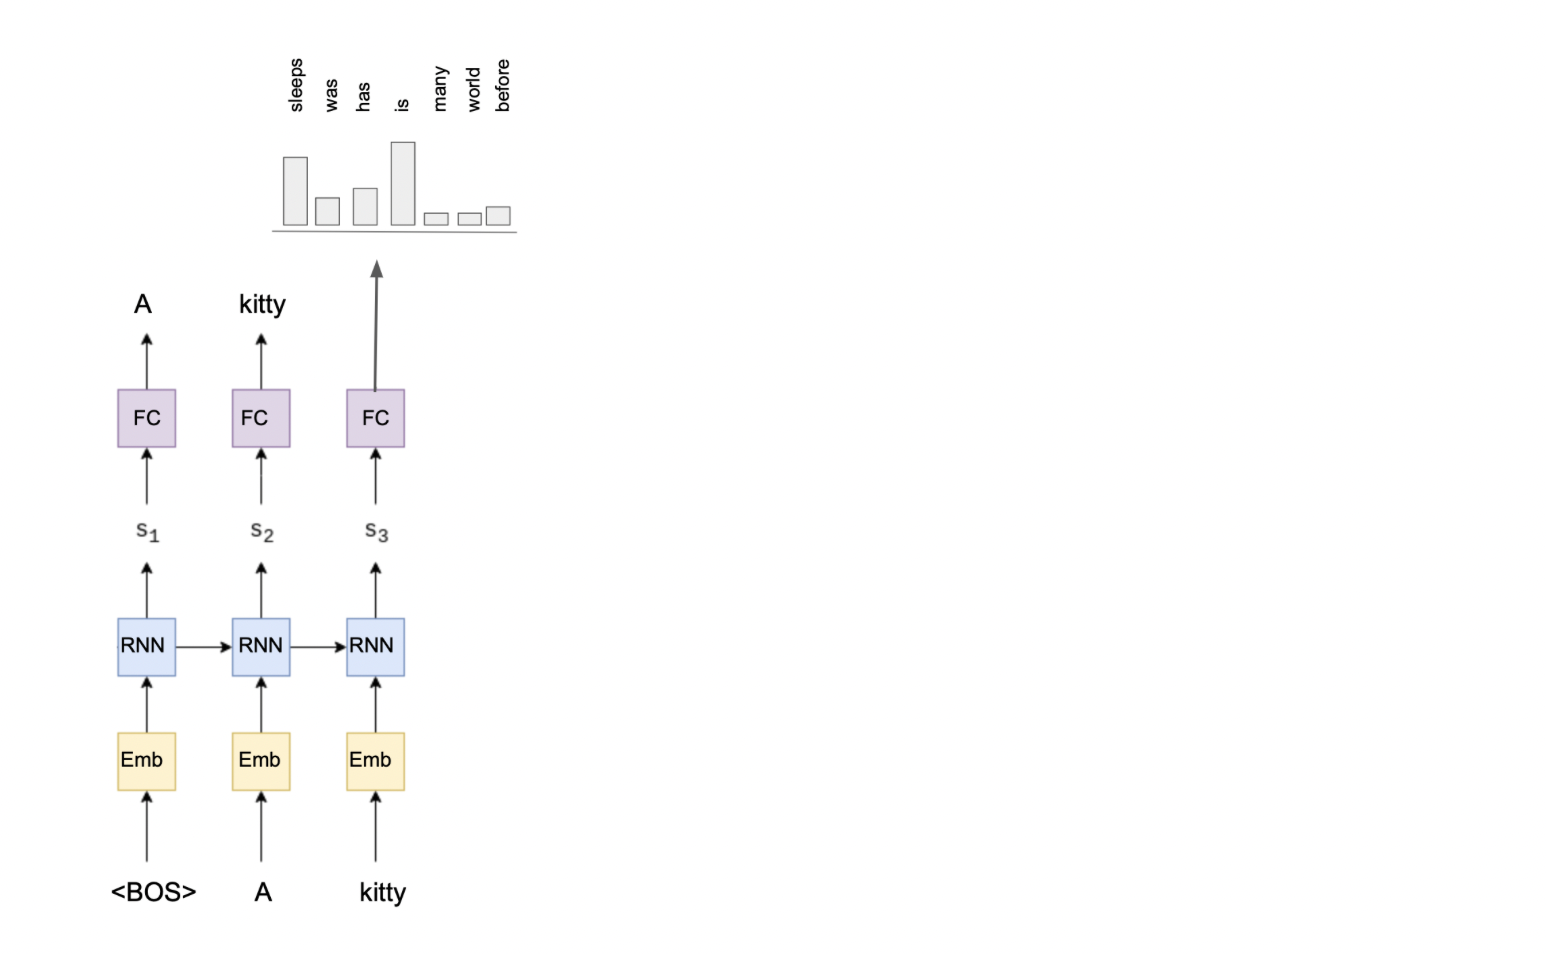

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        # сохраняем output_dim
        self.output_dim = output_dim

        # эмбеддинг слой декодера
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # для слоя Embedding будем использовать dropout
        self.dropout = nn.Dropout(dropout)

        # однослойная обычная GRU
        self.rnn = nn.GRU(emb_dim, dec_hid_dim)

        # полносвязный слой
        self.fc_out = nn.Linear(dec_hid_dim, output_dim)



    def forward(self, input, hidden):

        # (batch_size) - > (1, batch_size)
        input = input.unsqueeze(0)

        # (1, batch_size, emb_dim)
        embedded = self.dropout(self.embedding(input))

        output, hidden = self.rnn(embedded, hidden.unsqueeze(0))

        # (1, batch_size, emb_dim) - > (batch_size, emb_dim)
        # embedded = embedded.squeeze(0)
        # (1, batch_size, hidden_dim) - > (batch_size, hidden_dim)
        output = output.squeeze(0)

        # прогоняем
        prediction = self.fc_out(output)

        # возвращаем предсказание вероятности следующего токена
        # и скрытое состояние на текущем шаге
        return prediction, hidden.squeeze(0)

И, наконец, соберем Encoder и Decoder в одну большую сеть Seq2Seq

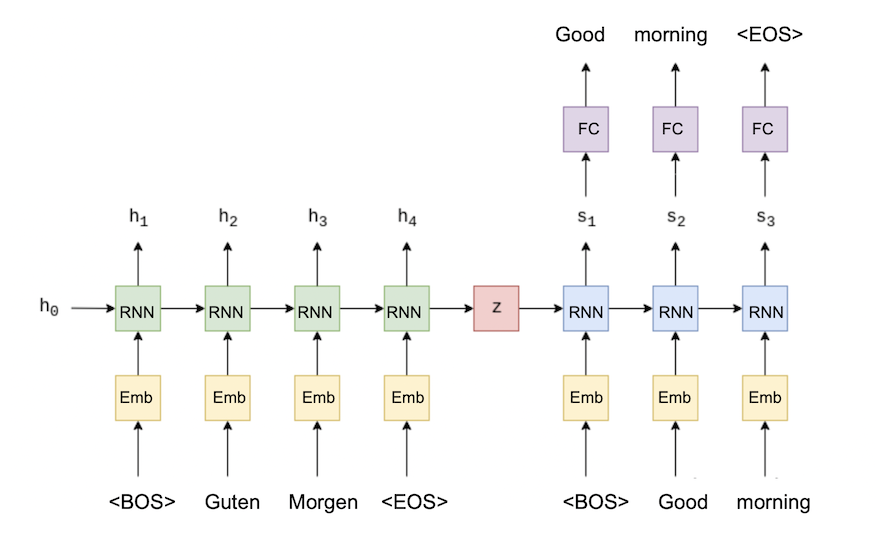

In [ ]:
import random


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        # массив для записи ответов декодера
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # получаем выход энкодера и его скрытые состояния
        encoder_outputs, hidden = self.encoder(src)

        #подаем в декодер токен <bos>
        input = trg[0,:]

        for t in range(1, trg_len):

            # подаем на вход эмбеддинги токенов и предыдущие скрытые состояния декодера
            # на выходе получаем выход сети (распределение вероятностей на следующий токен)
            # и новые скрытые состояния
            output, hidden = self.decoder(input, hidden)

            # кладем предсказания в массив outputs
            outputs[t] = output

            # решаем, будем ли использовать teacher forcing
            #teacher_force = random.random() < teacher_forcing_ratio

            # получаем самый вероятный токен
            top1 = output.argmax(1)

            # готовим инпут для следующей итерации
            input = trg[t] #if teacher_force else top1

        return outputs

Заводим Encoder, Decoder и Seq2Seq модель:

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# создаем энкодер
enc = Encoder(len(src_vocab), emb_dim=256, enc_hid_dim=512, dec_hid_dim=512, dropout=0.5).to(device)
# создаем декодер
dec = Decoder(len(trg_vocab), emb_dim=256, enc_hid_dim=512, dec_hid_dim=512, dropout=0.5).to(device)
# создаем Seq2Seq модель
model = Seq2Seq(enc, dec, device=device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
# лосс не будет считаться на токенах паддинга
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])

Обучаем модель:

In [ ]:
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm, trange


n_epochs = 10
clip = 1
for epoch in trange(n_epochs, desc="Epochs"):
    model.train()
    train_loss = 0

    # итерируемся по обучающему датасету
    for src, trg in tqdm(train_dataloader, desc="Train", leave=False):

        src, trg = src.to(device), trg.to(device)

        # подаем модели на вход пару предложений и для каждого
        # префикса tgt получаем предсказание следующего токена
        output = model(src, trg)

        # убираем первый элемент (<bos>) из подсчета лосса
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoch} train loss = {train_loss} ")

    # валидируем модель
    model.eval()

    val_loss = 0
    with torch.no_grad():
        for src, trg in tqdm(val_dataloader, desc="Val", leave=False):
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg)

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    print(f"Epoch {epoch} val loss = {val_loss} ")


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 0 train loss = 4.578646028250978 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0 val loss = 3.688625454902649 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 1 train loss = 3.586263186053226 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 val loss = 3.2744404077529907 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 2 train loss = 3.2024435850611903 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2 val loss = 2.978090822696686 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 3 train loss = 2.9162840487664208 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3 val loss = 2.7908642888069153 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 4 train loss = 2.6958098725268713 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4 val loss = 2.6524145007133484 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 5 train loss = 2.511885546801383 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5 val loss = 2.5485129952430725 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 6 train loss = 2.3568766409890696 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6 val loss = 2.4939581155776978 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 7 train loss = 2.2238384798953406 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7 val loss = 2.4204083681106567 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 8 train loss = 2.108381761793505 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8 val loss = 2.393494486808777 


Train:   0%|          | 0/114 [00:00<?, ?it/s]

Epoch 9 train loss = 2.000924409481517 


Val:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9 val loss = 2.3692352771759033 


Попробуем перевести 10 предложений из валидационных данных с помощью нашей обученной модели:

In [ ]:
trg_itos = trg_vocab.get_itos()
model.eval()
max_len = 50

with torch.no_grad():
    for src, trg in val_data[:10]:
        encoded = encode(src, src_vocab)
        encoded = torch.tensor(encoded)[:, None].to(device)
        # пропускаем предложение через encoder модели
        encoder_outputs, hidden = model.encoder(encoded)

        # задаем первый токен — bos
        pred_tokens = [trg_vocab[bos_token]]
        # в цикле генерируем перевод предложения токен за токеном
        for _ in range(max_len):
            decoder_input = torch.tensor([pred_tokens[-1]]).to(device)
            pred, hidden = model.decoder(decoder_input, hidden)
            _, pred_token = pred.max(dim=1)
            if pred_token == trg_vocab[eos_token]:
                # Don't add it to prediction for cleaner output.
                break

            pred_tokens.append(pred_token.item())

        print(f"src: '{src.rstrip().lower()}'")
        print(f"trg: '{trg.rstrip().lower()}'")
        print(f"pred: '{' '.join(trg_itos[i] for i in pred_tokens[1:])}'")
        print()

src: 'eine gruppe von männern lädt baumwolle auf einen lastwagen'
trg: 'a group of men are loading cotton onto a truck'
pred: 'a group of men are working on a <UNK> <UNK> .'

src: 'ein mann schläft in einem grünen raum auf einem sofa.'
trg: 'a man sleeping in a green room on a couch.'
pred: 'a man is sleeping in a chair in a room .'

src: 'ein junge mit kopfhörern sitzt auf den schultern einer frau.'
trg: 'a boy wearing headphones sits on a woman's shoulders.'
pred: 'a boy with glasses sitting on a bench reading a newspaper .'

src: 'zwei männer bauen eine blaue eisfischerhütte auf einem zugefrorenen see auf'
trg: 'two men setting up a blue ice fishing hut on an iced over lake'
pred: 'two men are performing a dance on a <UNK> <UNK> .'

src: 'ein mann mit beginnender glatze, der eine rote rettungsweste trägt, sitzt in einem kleinen boot.'
trg: 'a balding man wearing a red life jacket is sitting in a small boat.'
pred: 'a man with a yellow hat is sitting in a boat with a small boat in hi

## Дополнительно

- Лекции Deep Learning School по MT и Attention:
    - [Seq2Seq, машинный перевод](https://youtu.be/N3TLYsn0TU8?feature=shared);
    - [Внимание (Attention)](https://youtu.be/G4vT5cvJSxY?feature=shared);
    - [Семинар по Seq2Seq](https://youtu.be/d8A1nxoZDDk?feature=shared)
- Лекции Deep Learning School по врзитектуре Transformer:
    - Старые:
        - [Трансформеры. Self-Attention](https://youtu.be/f544TipD2QY?feature=shared);
        - [Трансформеры. Positional Encoding, Decoder side, Training](https://youtu.be/WL6UviEG3XA?feature=shared);
        - [Семинар. Трансформеры](https://youtu.be/KdMS5XWQAic?feature=shared)
    - Новые:
        - [Трансформеры: главные идеи](https://youtu.be/lK0hqrVHrUA?feature=shared);
        - [Трансформеры: вспомогательные элементы](https://youtu.be/cKPDBXjD9lo?feature=shared);
        - [Трансформеры: особенности обучения, вариации](https://youtu.be/BgFqtC866qE?feature=shared)
- [Статья про Bidirectional RNN](https://d2l.ai/chapter_recurrent-modern/bi-rnn.html) (на английском)
- [Лекция Андрея Созыкина про GRU и LSTM](https://youtu.be/Kv4NyVW9IZ4?feature=shared)
- [Статья про LSTM](https://neerc.ifmo.ru/wiki/index.php?title=Долгая_краткосрочная_память)
- [Статья про историю развития машинного перевода](https://vc.ru/future/32616-mashinnyy-perevod-ot-holodnoy-voyny-do-glubokogo-obucheniya)